In [ ]:
import torch
import corner
import numpy as np
import pylab as plt
from swyft.intensity import BallMask, ComboMask, Prior1d, Prior, IntensityNew
from tqdm import tqdm
import xarray

import swyft

DEVICE = 'cuda'

%load_ext autoreload
%autoreload 2

In [2]:
N = 1000
cache = swyft.MemoryCache(par_names = ["A", "B"], obs_shapes = {"img": (10,)})
p1 = Prior({"A": ["normal", 0.0, 1.0], "B": ["normal",  0., 1.0]}, mask = None)
cache.grow(p1, N)

Creating new cache.
(980,)
(980,)
Adding 980 new samples. Run simulator!


In [3]:
def model(par):
    return dict(img=np.random.randn(10,)*par['A']+par['B'])
cache.simulate(model)

Simulate: 100%|██████████| 980/980 [00:02<00:00, 385.58it/s]


In [4]:
indices = cache.sample(p1, N)
points = swyft.Points(cache, indices, None)
points[0]

{'obs': {'img': array([0.4999469 , 0.50192379, 0.50989676, 0.50203356, 0.47258564,
         0.53511687, 0.50897512, 0.5038733 , 0.49547458, 0.52651618])},
 'par': {'A': 0.02557866834104061, 'B': 0.4999833106994629}}

In [5]:
combinations = [("A"), ("B"), ("A", "B")]
transform = swyft.Transform(combinations)

In [6]:
ds = swyft.Dataset(points, transform)
ds[0]

{'obs': {'img': tensor([0.4999, 0.5019, 0.5099, 0.5020, 0.4726, 0.5351, 0.5090, 0.5039, 0.4955,
          0.5265])},
 'par': tensor([[0.0256, 0.0000],
         [0.5000, 0.0000],
         [0.0256, 0.5000]])}

In [7]:
re = swyft.RatioEstimator(ds, device=DEVICE)

Number of features from head network: 10
Number of parameters to estimate: 3
Maximum posterior dimensionality: 2


In [8]:
re.train(max_epochs=2, batch_size=8, lr_schedule=[1e-3, 1e-4])

Start training
LR iteration 0
Validation loss: 68.20758867263794
Validation loss: 65.4676866531372
Total epochs: 2
LR iteration 1
Validation loss: 63.25886917114258
Validation loss: 62.8760871887207
Total epochs: 2


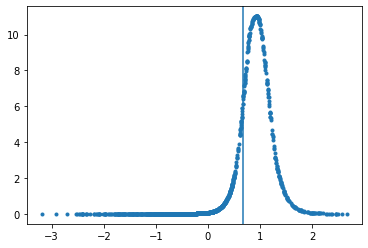

In [9]:
i = 3
obs = points[i]['obs']
par = p1.sample(1100)
lnL = re.lnL(obs, par, transform)
plt.plot(par['B'], np.exp(lnL['B']), ls='', marker='.')
plt.axvline(points[i]['par']['B'])

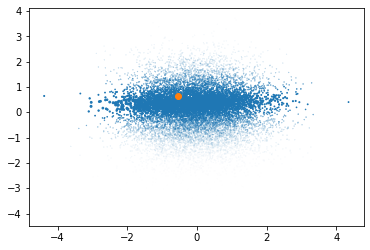

In [10]:
i = 2
obs, par = points[i]['obs'], points[i]['par']
pars = p1.sample(10000)
lnL = re.lnL(obs, pars, transform)
plt.scatter(pars['A'], pars['B'], np.exp(lnL[('A', 'B')]))
plt.scatter(par['A'], par['B'], marker='o')

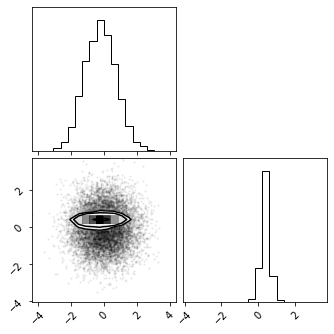

In [12]:
corner.corner(np.stack([pars['A'], pars['B']]).T, weights = np.exp(lnL[('A','B')]));

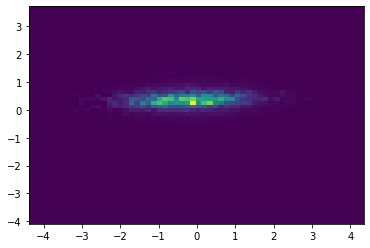

In [13]:
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B')]), bins = 60, density = True);